# This NoteBook is for Preprocessing the External Image Dataset

# Importing packages

In [1]:
import os

import pandas as pd
import numpy as np

import cv2
import matplotlib.pylab as plt

from glob import glob as glob
from pathlib import Path


# Preprocessing Images

In [2]:
crack_srcdir = Path("../data/external/Crack")
noncrack_srcdir = Path("../data/external/Non-crack")

Noncrack_processed_dir = Path("../data/processed/pro_noncrack_img")
Crack_processed_dir = Path("../data/processed/pro_crack_img")

In [3]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [4]:
crack_df = generate_df(crack_srcdir, label="CRACK_IMAGE")
noncrack_df = generate_df(noncrack_srcdir,label="NONCRACK_IMAGE")
total_df = pd.concat([crack_df,noncrack_df],axis=0).sample(frac=1.0,random_state=1).reset_index(drop=True)

total_df

,Filepath,Label
0,..\data\external\Crack\03842.jpg,CRACK_IMAGE
1,..\data\external\Crack\12899_1.jpg,CRACK_IMAGE
2,..\data\external\Crack\15033_1.jpg,CRACK_IMAGE
3,..\data\external\Non-crack\16782.jpg,NONCRACK_IMAGE
4,..\data\external\Crack\09202.jpg,CRACK_IMAGE
...,...,...
39995,..\data\external\Crack\07814.jpg,CRACK_IMAGE
39996,..\data\external\Non-crack\12512.jpg,NONCRACK_IMAGE
39997,..\data\external\Crack\05193.jpg,CRACK_IMAGE
39998,..\data\external\Crack\12173_1.jpg,CRACK_IMAGE


# Original Images Displaying (Crack)

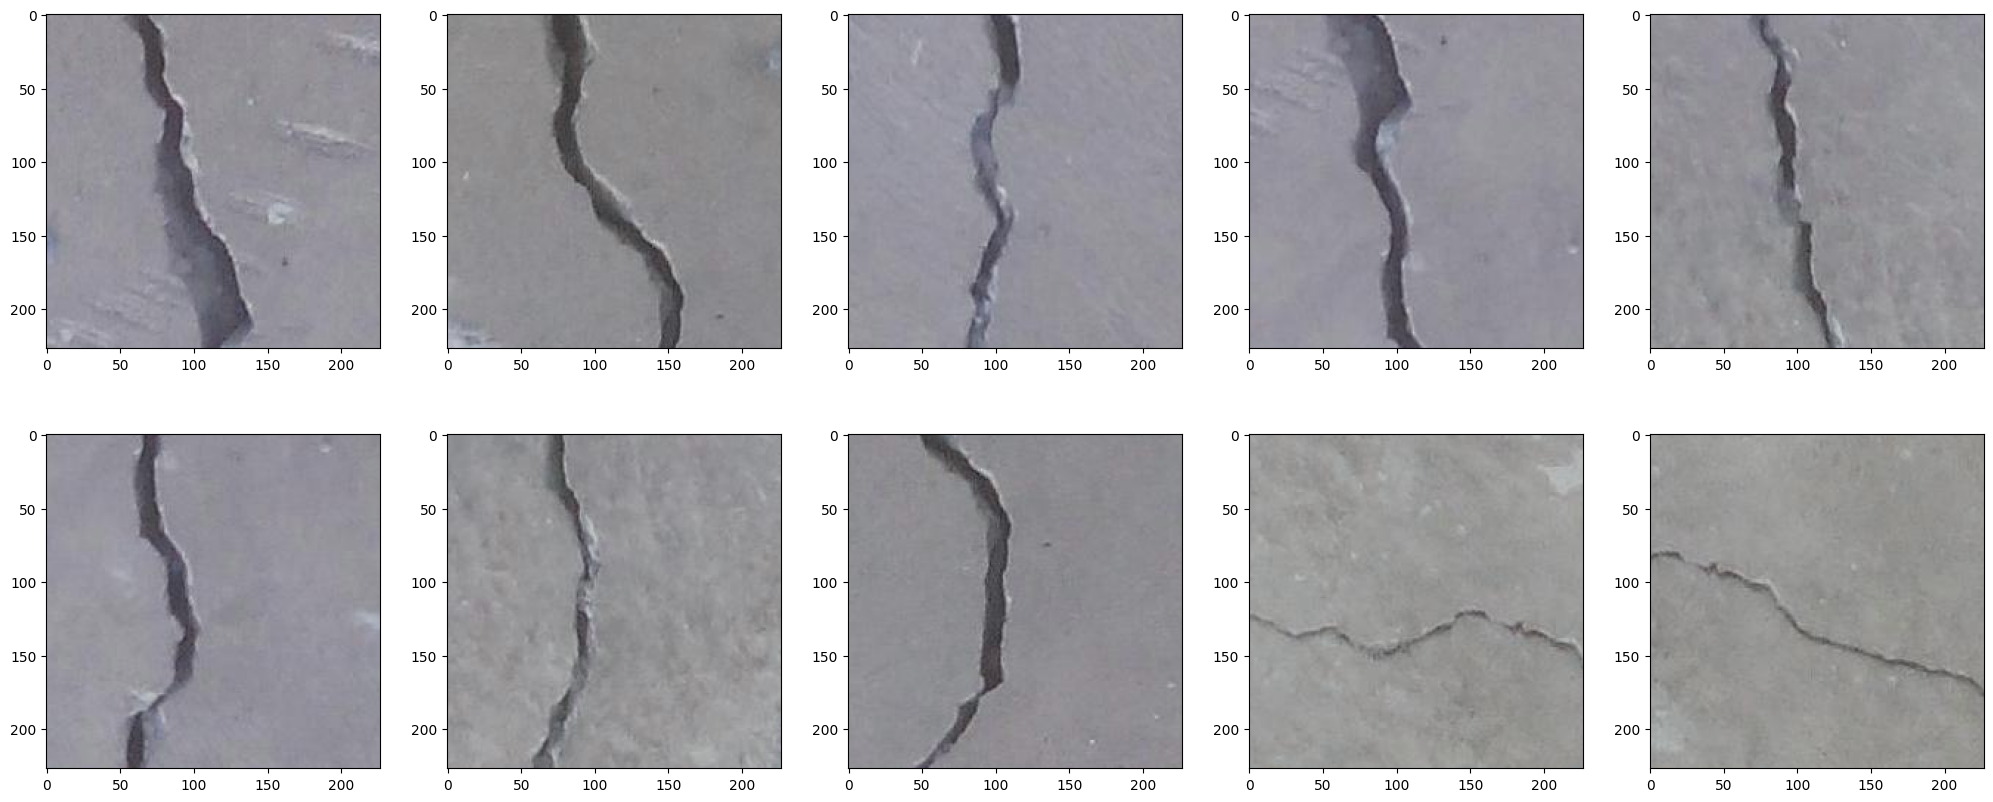

In [5]:
size = len(crack_df)
rows=2
cols = 5
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols,5*rows))

for i in range(rows):
    for j in range(cols):        
        if img_count <size:
            axes[i, j].imshow(cv2.imread(os.path.join(crack_srcdir, os.listdir(crack_srcdir)[img_count+10])))
            img_count+=1

# Original Images Displaying (Non-Crack)

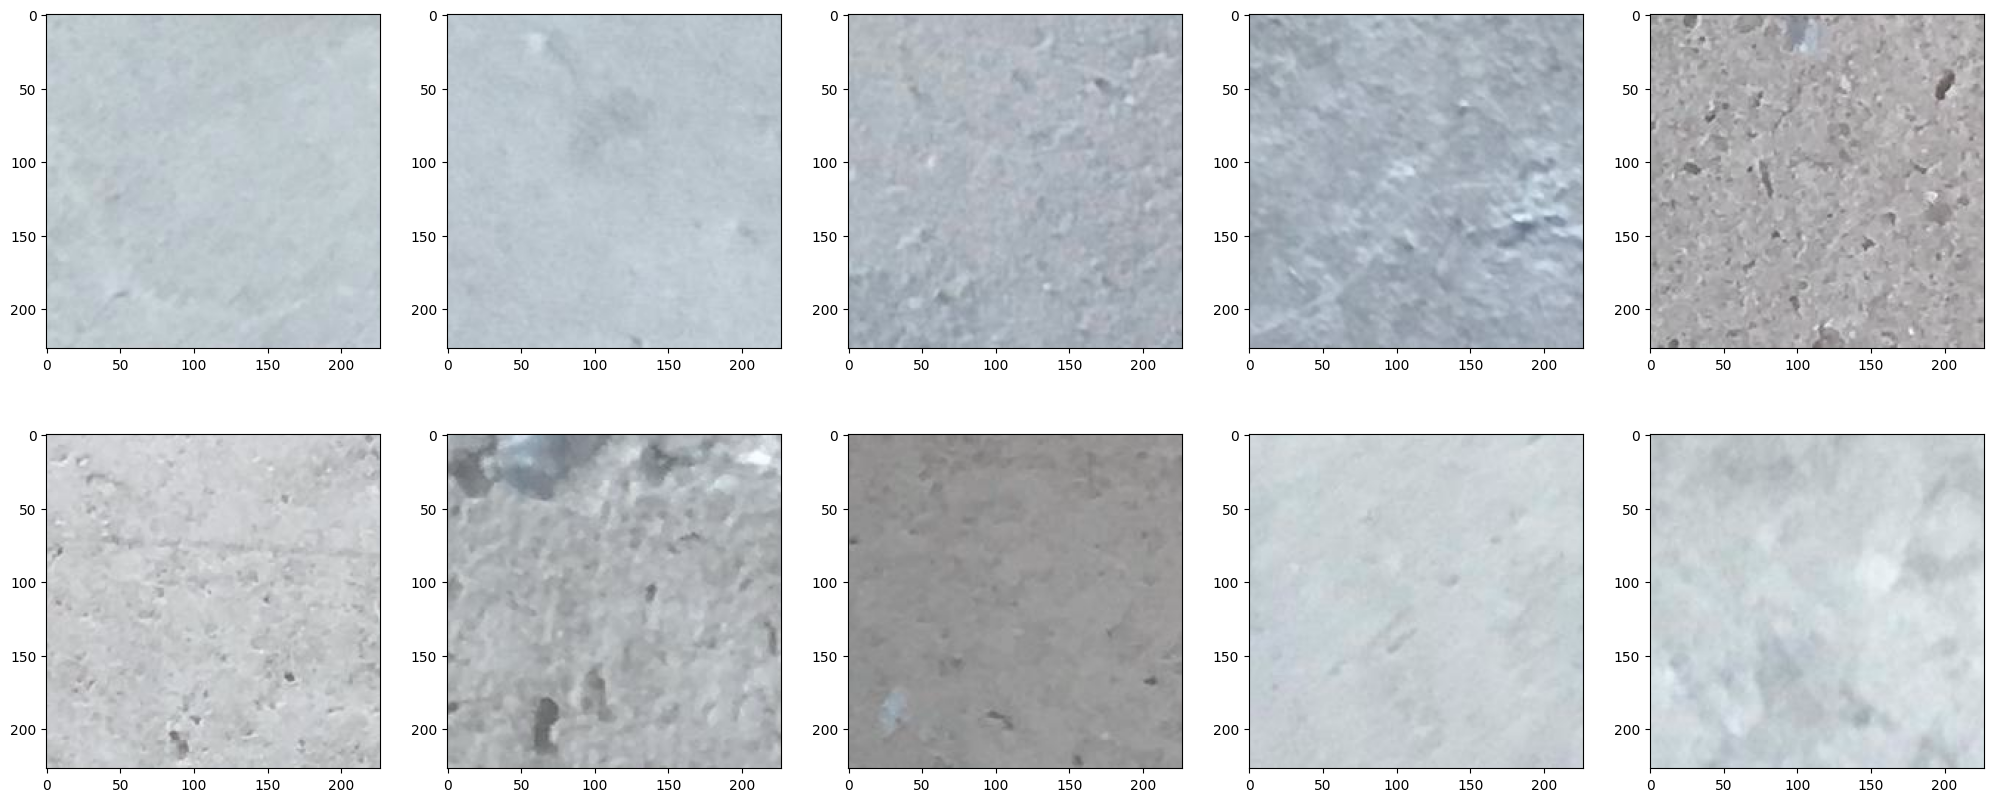

In [6]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols,5*rows))

for i in range(rows):
    for j in range(cols):        
        if img_count <size:
            axes[i, j].imshow(cv2.imread(os.path.join(noncrack_srcdir, os.listdir(noncrack_srcdir)[img_count])))
            img_count+=1

# Adaptive Canny and Flood-Fill algorithm

In [8]:
import cv2
from collections import deque

def percolation_fill(img, gap_threshold=2):
    h, w = img.shape
    visited = np.zeros_like(img, dtype=bool)
    result = np.zeros_like(img)

    directions = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]

    def is_valid(y, x):
        return 0 <= y < h and 0 <= x < w

    def bfs(y, x):
        q = deque()
        q.append((y, x))
        visited[y, x] = True

        while q:
            cy, cx = q.popleft()
            result[cy, cx] = 255

            for dy, dx in directions:
                ny, nx = cy + dy, cx + dx
                if is_valid(ny, nx) and not visited[ny, nx]:
                    if img[ny, nx] > 0:
                        visited[ny, nx] = True
                        q.append((ny, nx))
                    else:
                        # Try to bridge the gap
                        for g in range(1, gap_threshold + 1):
                            gy, gx = cy + dy * g, cx + dx * g
                            if is_valid(gy, gx) and img[gy, gx] > 0 and not visited[gy, gx]:
                                # Fill intermediate gap
                                for i in range(g + 1):
                                    fy, fx = cy + dy * i, cx + dx * i
                                    if is_valid(fy, fx):
                                        result[fy, fx] = 255
                                        visited[fy, fx] = True
                                q.append((gy, gx))
                                break

    for y in range(h):
        for x in range(w):
            if img[y, x] > 0 and not visited[y, x]:
                bfs(y, x)

    return result

def smart_percolation_fill(img):
    # Stage 1: conservative fill to preserve thin crack detail
    conservative_fill = percolation_fill(img, gap_threshold=15)

    # Stage 2: aggressive fill for longer cracks (connect major gaps)
    aggressive_fill = percolation_fill(conservative_fill, gap_threshold=18)

    # Merge both with OR (preserves both detail and coverage)
    fine_made = cv2.bitwise_or(conservative_fill, aggressive_fill)

    return fine_made


def preprocess_image(image_path):
    img = cv2.imread(str(image_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
    blurred = cv2.GaussianBlur(gray, (1, 1), 1)
    blurred = cv2.bilateralFilter(blurred, 9, 15, 15)
    # Use median to find optimal Canny thresholds
    v = np.median(blurred)
    lower = int(max(0, 0.66 * v)) - 90
    upper = int(min(255, 1.33 * v)) + 15
    edges = cv2.Canny(blurred, lower, upper)
    kernel = np.ones((3, 3), np.uint8)
    smoothened_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=1)
    # Use custom percolation fill to connect broken cracks
    filled_edges = smart_percolation_fill(smoothened_edges)
    morph_kernel = np.ones((3, 3), np.uint8)
    filled_edges = cv2.morphologyEx(filled_edges, cv2.MORPH_CLOSE, morph_kernel, iterations=5)

 
    return filled_edges

In [9]:
def plot_images(images, category):
    cols = 5
    rows = 2
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap="gray")
        ax.set_title(f"{category} Image {i+1}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

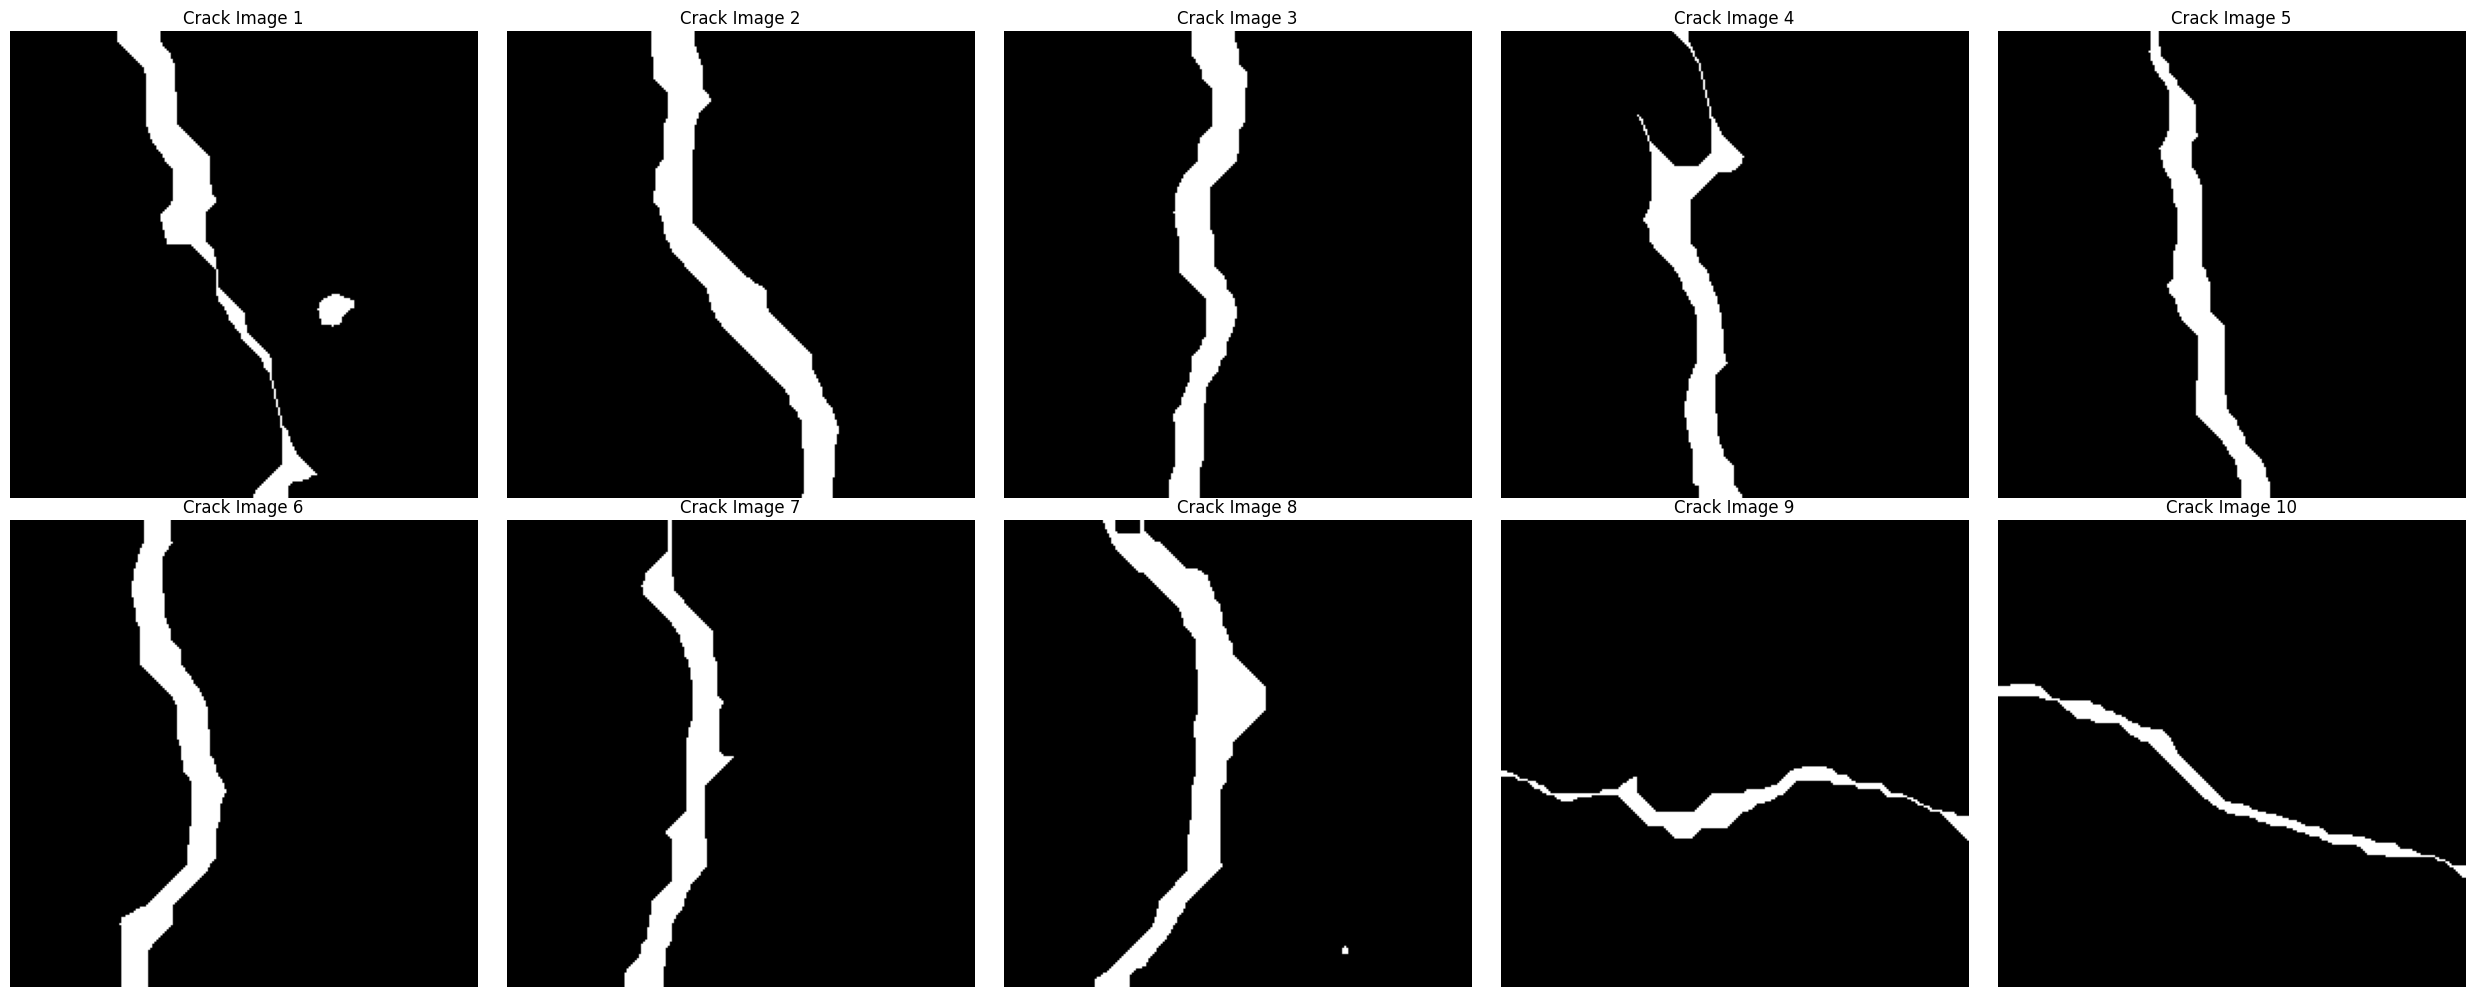

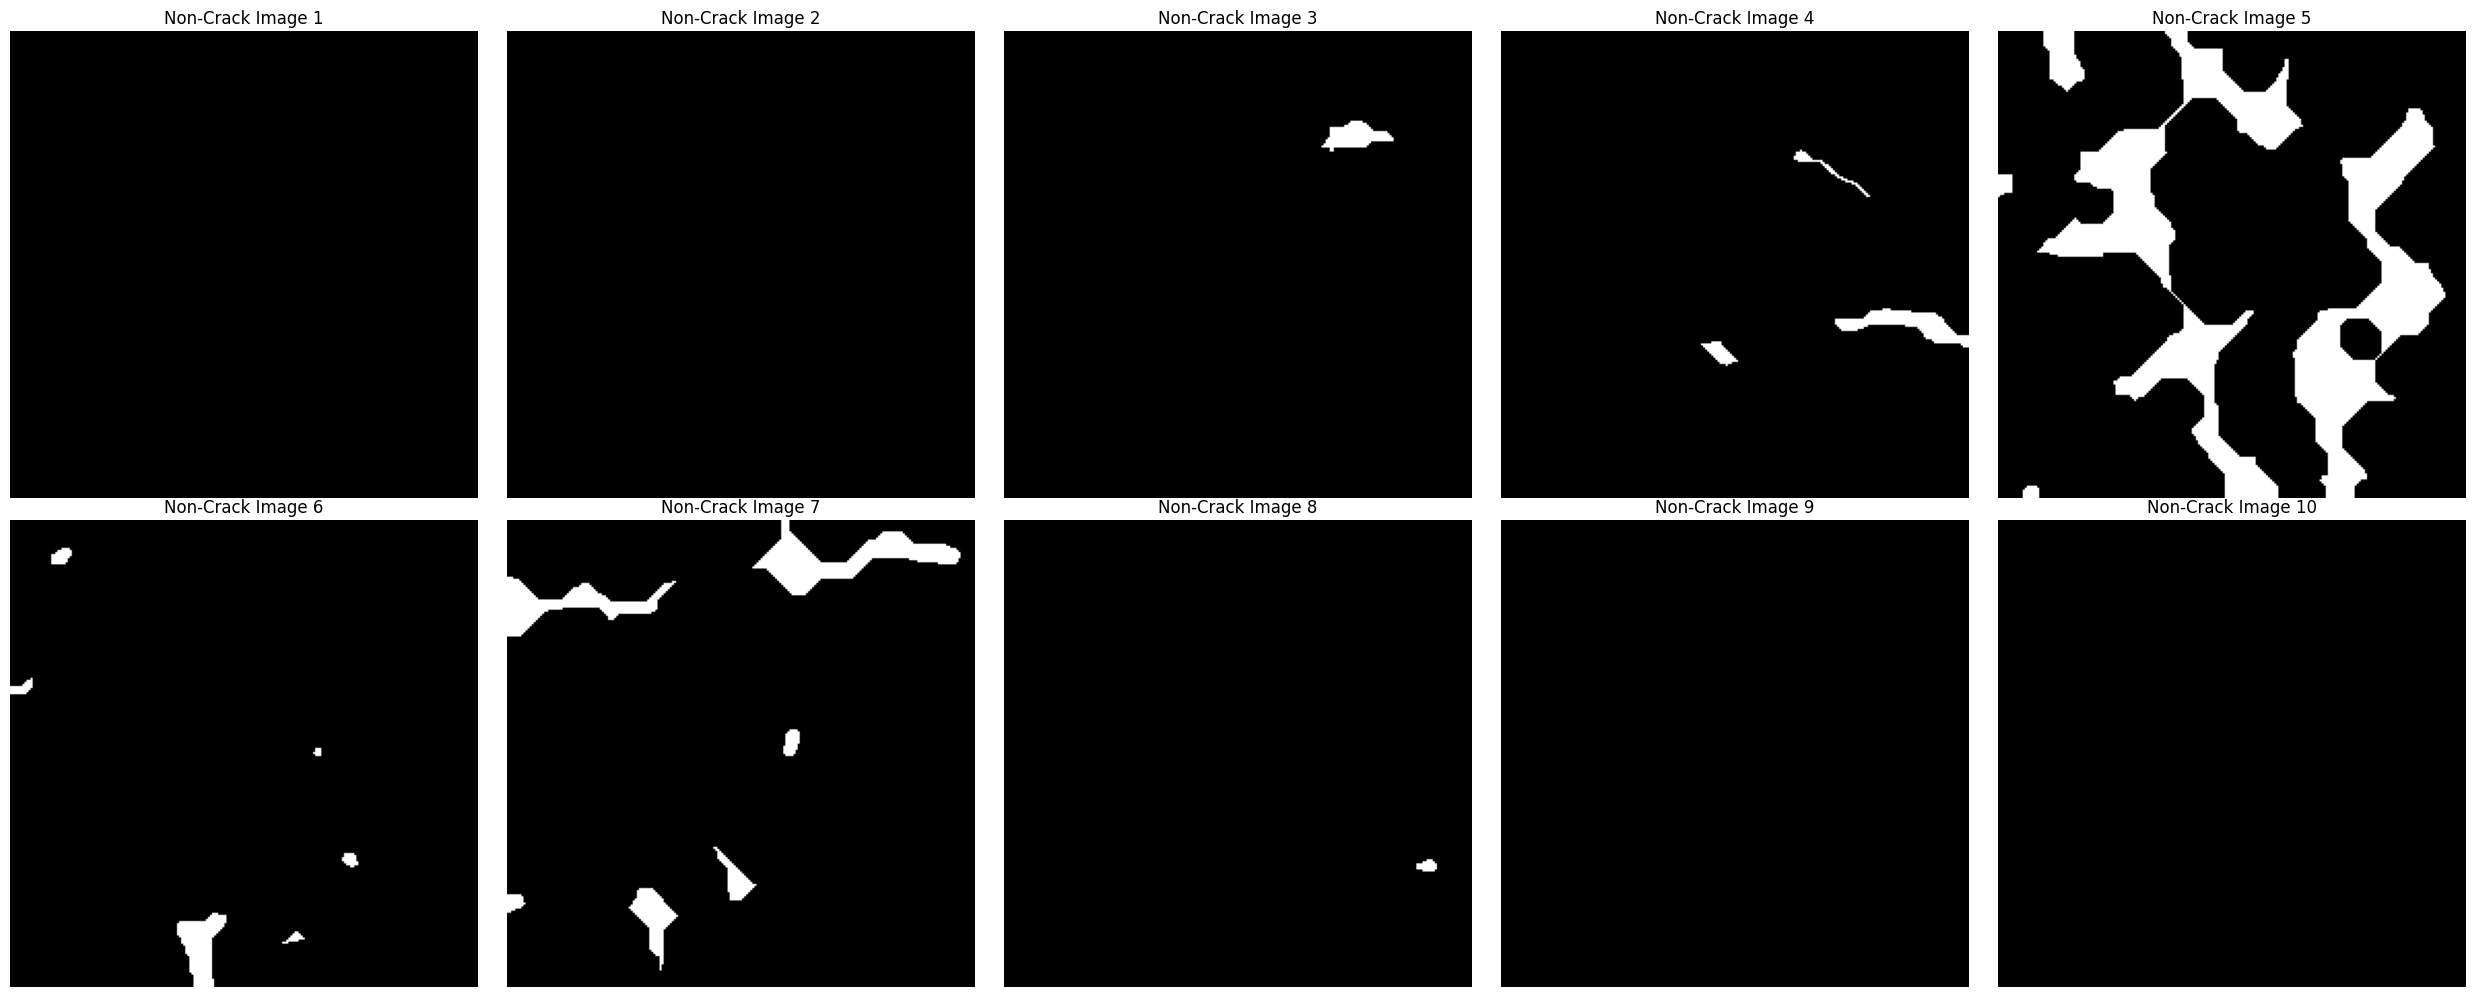

In [10]:
# crack_temp = Path("../data/processed/crack_temp")
# crack_temp.mkdir(parents=True, exist_ok=True)

# Process and visualize first 100 Crack images
crack_images = list(crack_srcdir.glob("*.jpg"))[10:20]
crack_processed = [preprocess_image(img) for img in crack_images]
plot_images(crack_processed, "Crack")

# Save after visualization
for i, image_path in enumerate(crack_images):
    output_path = Crack_processed_dir / image_path.name
    cv2.imwrite(str(output_path), crack_processed[i])
    
crack_processed[:1]
# Process and visualize first 10 Non-Crack images
noncrack_images = list(noncrack_srcdir.glob("*.jpg"))[10:20]
noncrack_processed = [preprocess_image(img) for img in noncrack_images]
plot_images(noncrack_processed,"Non-Crack")

# Save after visualization
# for i, image_path in enumerate(noncrack_images):
#     output_path = Noncrack_processed_dir / image_path.name
#     cv2.imwrite(str(output_path), noncrack_processed[i])
# noncrack_processed[:1]


# PREPROCESSING COMPLETED